In [13]:
import lettuce as lt
import matplotlib.pyplot as plt

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet

import torch
import time
import datetime
import os
import shutil

In [14]:
### Simulationsparameter - Steuerung 
re = 200    # Reynoldszahl
n_steps = 100    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_ou -> this defines the PU-Reference velocity (u_max of inflow)

gridpoints_per_diameter = 3  # gp_per_D -> this defines the resolution
domain_width_in_D = 3  # D/Y  -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X

print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", n_steps * (setup_diameter/gridpoints_per_diameter)*(0.05*1/np.sqrt(3)/flow_velocity), "seconds")
print("n_steps to simulatate 1 second:", (gridpoints_per_diameter/setup_diameter)*(flow_velocity/(0.05*1/np.sqrt(3))), "steps")

timestamp = datetime.datetime.now()
timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
dir_name = "/data_" + str(timestamp)
os.makedirs(output_path+dir_name)

u_init = 2    # initiales Geschwindigkeitsfeld: 1= alle null, 2= parabelförmiger Verlauf über den Kanal-Qerschnitt
perturb_init = True   # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> Amplitude kann unten gewählt werden
u_in_parabel = True    # Anströmungsprofil: True=parabelförmig, False=uniform
bb_wall = True    # Randbedingungen der lateralen Kanalwände: True= bounce-back-walls, False= periodic
cylinder = True    # Objekt: True = cylinder, False = no obstascle
halfway = True    # BounceBackBoundary: True=halfway, False=Fullway
vtk_out = True    # vtk-Repoter für Animation des Flusses in ParaView: True = vtk-output, False = no vtk-output
vtk_path = output_path+dir_name+"/vtk/out"    # lokal HBRS # Pfad und Name der vtk-output-Dateien
#vtk_path = output_path+dir_name+"/vtk/out"  # lokal Bonn
vtk_fps=10    # FramesPerSecond (/PU) für vtk-output
drag_out = True    # drag_coefficient als observable-reporter
lift_out = True    # lift_coefficient als observable-reporter

print("dir_name: "+dir_name)
print("output_path: " + vtk_path)

#exmpl: Re1000,steps25000,ny1000 braucht 43min

shape_LU: 18 x 9
T with 100 steps: 0.9622504486493763 seconds
n_steps to simulatate 1 second: 103.92304845413263 steps
dir_name: /data_230309_145913
output_path: /mnt/ScratchHDD1/Max_Scratch/lbm_simulations/data_230309_145913/vtk/out


In [15]:
### EINLASS-Randbedingung
### Modifizierte EquilibrimuBoundaryPU aus boundary.py, welche die Möglichkeit eines parabelförmigen
### Geschwindigkeitsprofils am Einlass erlaubt (ähnlich zu Poiseuille-Flow)

class EquilibriumBoundaryPU:
    """Sets distributions on this boundary to equilibrium with predefined velocity and pressure.
    Note that this behavior is generally not compatible with the Navier-Stokes equations.
    This boundary condition should only be used if no better options are available.
    """

    def __init__(self, mask, lattice, units, velocity, pressure=0):
        # parameter input (u, p) in PU!
        self.mask = lattice.convert_to_tensor(mask)
        self.lattice = lattice
        self.units = units
        self.velocity = lattice.convert_to_tensor(velocity)  # inlet-velocity in PU
        self.pressure = lattice.convert_to_tensor(pressure)  # inlet-pressure in PU
        self.u_inlet = self.units.convert_velocity_to_lu(self.velocity) # ein Tensor: tensor([0.0289, 0.0000], device='cuda:0')
        # calculate uniform or parabolic inlet-velocity-distibution
        if u_in_parabel:
            ## Parabelförmige Geschwindigkeit, vom zweiten bis vorletzten Randpunkt (keine Interferenz mit lateralen Wänden (BBB  oder periodic))
                ## How to Parabel:
                ## 1.Parabel in Nullstellenform: y = (x-x1)*(x-x2)
                ## 2.nach oben geöffnete Parabel mit Nullstelle bei x1=0 und x2=x0: y=-x*(x-x0)
                ## 3.skaliere Parabel, sodass der Scheitelpunkt immer bei ys=1.0 ist: y=-x*(x-x0)*(1/(x0/2)²)
                ## (4. optional) skaliere Amplitude der Parabel mit 1.5, um dem Integral einer homogenen Einstromgeschwindigkeit zu entsprechen
            ny = mask.shape[1]  # Gitterpunktzahl in y-Richtung
            ux_temp = np.zeros((1,ny))  # x-Geschwindigkeiten der Randbedingung
            y_coordinates = np.linspace(0,ny,ny)  # linspace() erzeugt n Punkte zwischen 0 und ny inklusive 0 und ny, so wird die Parabel auch symmetrisch und ist trotzdem an den Rändern NULL
            ux_temp[:,1:-1] = - np.array(self.u_inlet.cpu()).max() * y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1/(ny/2)**2 
                # (!) es muss die charakteristische Geschwindigkeit in LU genutzt werden (!) -> der Unterschied PU/LU ist u.U. Größenordnungen und es kommt bei falscher Nutzung zu Schock/Überschall und somit Sim-Crash
                # Skalierungsfaktor 3/2=1.5 für die Parabelamplitude, falls man im Integral der Konstantgeschwindigkeit entsprechenn möchte.
                # in 2D braucht u1 dann die Dimension 1 x ny (!)
            uy_temp = np.zeros_like(ux_temp)  # y-Geschwindigkeit = 0
            self.u_inlet = np.stack([ux_temp, uy_temp], axis=0) # verpacke u-Feld
            self.u_inlet = self.lattice.convert_to_tensor(self.u_inlet)  # np.array to torch.tensor
            print("parabelförmiger Einluss")
        else:
            print("uniformer Einfluss")
        print("die hier definierte ipynb-Version der EqBoundaryPU wurde genutzt :)")

    def __call__(self, f):
        # convert PU-inputs to LU, calc feq and overwrite f with feq where mask==True
        rho = self.units.convert_pressure_pu_to_density_lu(self.pressure)
        feq = self.lattice.equilibrium(rho, self.u_inlet)  # Berechne Gleichgewicht mit neuer Geschwindigkeit
        feq = self.lattice.einsum("q,q->q", [feq, torch.ones_like(f)])  # erweitere auf komplettes Feld, falls nötig (feq "breit" ziehen in x-Richtung)
        f = torch.where(self.mask, feq, f)  # überschreibe f am Einlass mit feq
        return f

In [16]:
### flow/Cylinder2D: modifizierte flows/obstacle.py Klasse, zur Simulation eines umströmten Zylinders im 2D-Kanal
# nicht zu verwechseln mit flows/cylinder2D.py im development- und dragAndForce-branch

class Cylinder2D:

    def __init__(self, 
                 #shape, 
                reynolds_number, mach_number, lattice, 
                 #domain_length_x, 
                 #diameter, 
                char_length=1,  # diameter of the cylinder (PU)
                char_length_lu=10,  # gridpoints per diameter (resolution)
                char_velocity=1,  # u_max inflow (PU)
                y_d=5, x_d=10):  # domain in No. of diameters
        
        # old    # kontrolliere shape-Angabe in Bezug auf die lattice-Dimensionen
            #if len(shape) != lattice.D:  
            #    raise ValueError(f"{lattice.D}-dimensional lattice requires {lattice.D}-dimensional `shape`")
        # übernehme Objektreferenzen, berechne char_length_lu, übernehme Kennzahlen (Re, Ma, l_char, u_char)
        self.shape = (x_d*char_length_lu, y_d*char_length_lu)  # Domain-grid in [nx,ny]
        self.diameter_pu = char_length
        self.domain_length_D = x_d
        self.domain_width_D = y_d
        
        # initilalisiere UnitConverter
            # defaults: l_char_pu=l_char_lu=u_char_pu=1 // rho_char_lu=rho_char_pu=1, Ma=0.05
        self.units = UnitConversion(  
            lattice,
            reynolds_number=reynolds_number,
            mach_number=mach_number,
            characteristic_length_lu=char_length_lu,
            characteristic_length_pu=char_length,
            characteristic_velocity_pu=char_velocity  ### reminder: u_char_lu = Ma * cs_lu = Ma * 1/sqrt(3)
        )
        
        # bool-Maske, welche alle Nicht-Fluid-Knoten markiert (shape: nx x ny (x nz))
            # ...und als Prototyp für BounceBackBoundary-Masken (Wände, Obstacle) dient
        self._mask = np.zeros(shape=self.shape, dtype=bool)  #deprecation warning: "np.bool"...ist ein alter alias für das buildin "bool"
        # belege Boundary-Masken:
        # inlet
        self.in_mask = np.zeros(self.grid[0].shape, dtype=bool)  # dimensioniere in_mask
        self.in_mask[0, 1:-1] = True  # Einlass: erste Spalte, ohne laterale Wände
        # lateral walls
        self.wall_mask = np.zeros_like(self._mask)
        if bb_wall == True:
            self.wall_mask[:, [0, -1]] = True  # laterale Wände markieren (ohne letzte Spalte, da dort "outlet_boundary" definiert ist)
            self._mask[np.where(self.wall_mask)] = 1  # übernehme Wände in BBB-Maske
        #obstacle
        self.obstacle_mask = np.zeros_like(self._mask)
###############################################
        radius = 0.5 * self.diameter_pu # radius of cylinder obstacle in PU
        x_pos = 0.25 * self.domain_length_D * self.diameter_pu # x_pos of center of cylinder in PU
        y_pos = 0.5 * self.domain_width_D  # y_pos of center of cylinder in PU

        x, y = self.grid #gibt ein Meshgrid zurück: x-2D-Array, y-2D-Array
            # in der ursprünglichen Implementierung von grid mit "arange(n)" reicht das grid für n=10 z.B. von 0 bis 9... d.h. die Position 5 ist nicht in der Mitte (!)
            # in Cylnider2D (s.o.) ist das grid mit linspace erstellt und geht für n Punkte von 0 bis n inklusive 0 und n als Randpunkte

        # Zylinder - Kreisgleichung (x-x0)²+(y-y0)²<r² in PU
        condition = np.sqrt((x-x_pos)**2+(y-y_pos)**2) < radius #die Kreisgleichung rechnet in PU, d.h. die Auflösung spielt hier keine Rolle(!)
        # area=2*radius  # die angeströmte Querschnittsfläche (zur Berechnung des drag coefficient): A=2*r in 2D, ! area is in PU
        self._mask[np.where(condition)] = 1  # übernehme Obstacle Form (mask als Bool) in BBB-Maske
        self.obstacle_mask[np.where(condition)] = 1  # definiere Obstacle Form (ohne andere Wände), für Kraftberechnung
################################################
    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, m):
        # Maskenbelegung wird auf korrekten Datentyp und Dimension getestet
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._mask = m.astype(bool)  #deprecation warning: "np.bool" ist ein alter alias für das buildin "bool"

    ### DEFINIERE ANFANGSBEDINGUNG
    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_max_lu = self.units.characteristic_velocity_lu * self._unit_vector()
        u_max_lu = append_axes(u_max_lu, self.units.lattice.D) # u_char_pu=1, u_char_lu = Ma * cs_lu
        u = (1 - self.mask) * u_max_lu # initialisiere Geschwindigkeitsfeld: alles was nicht obstacle ist, wird u_char_lu gesetzt
### Wähle initiale Geschwindigkeitsverteilung: (flag u_init={1,2})
        #u_init = 1 
            # 1: uniform u=0
            # 2: uniform parabolic, apmplitude u_char_lu (similar to poiseuille-flow)
        if u_init == 1: # no velocity
            ### initiale velocity u=0
            u = u * 0
            print("initial u=0")
        elif u_init ==2: # parabolic along y, uniform along x (similar to poiseuille-flow)
            ### initiale Geschwindigkeitsverteilung parabelförmig (0 auf lateralen Wänden, dazwischen Parabel)
            ny = self.shape[1]  # Gitterpunktzahl in y-Richtung           
            ux_factor=np.zeros(ny)  # Vektor für erste Spalte (u(x=0)) des u-Feldes
            # Geschwindigkeitsparabel mit Amplitude 1 (zur Aufmultiplikation auf das gesamte Geschwindigkeitsfeld, s.u.)
            y_coordinates = np.linspace(0,ny,ny)  # linspace() erzeugt n Punkte zwischen 0 und ny inklusive 0 und ny, so wird die Parabel auch symmetrisch und ist trotzdem an den Rändern NULL
            ux_factor[1:-1] = - y_coordinates[1:-1] * (y_coordinates[1:-1] - ny) * 1/(ny/2)**2 
            #print("u1-Parabel aus initial_solution: ", u1)
            u=np.einsum('k,ijk->ijk',ux_factor,u) # multipliziere jede Geschwindigkeits-Spalte mit der Parabel            
            print("initial u=poiseille")
        else:
            print("initial u=u_char_lu uniform")

### Störe Initialverteilung für Asymmetrie und Ausbildung einer Karman'schen Wirbelstraße
        #perturb_init = True
        if perturb_init:
            # überlagere Sinus-Störung in ux über die zweite Spalte u(x=1)
            ny = x[1].shape[1]
            if u.max() < 0.5*self.units.characteristic_velocity_lu:
                # Addition der Parabel, falls das initiale Geschwindigkeitsfeld sehr kleine Werte hat (z.B. null ist)
                u[0][1] += np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_lu * 1.0
            else:
                # sonst Multiplikation mit der Parabel (und Faktor 0.3 gegen Instabilität/Schocks)
                u[0][1] *= 1 + np.sin(np.arange(0, ny) / ny * 2 * np.pi) * 0.3
            # kontrolliere gestörtes u(x=1,y=:) durch plotting:
            #print("perturbed inlet-velocity:")
            #plt.plot(u[0][1])
            #plt.show()
        return p, u

    @property
    def grid(self):
        # erstelle MESHGRID: Koordinatenverteilung (Positionen in PU) über das nx x xy Raster und gibt je ein x- und ein y-2D-Array zurück
            # linspace erlaubt endpoint=True im Gegensatz zu Arange "np.linspace(0,n,n)" war vorher "np.arange(n)"
            # d.h. von 0 bis n enthält auch 0 und n als Anfangs und Endpunkte und nicht n-1
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0,n,n)) for n in self.shape)  # Tupel aus Listen der x-Wert, y-Werte, (und z-Werte)
        return np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Werten

    @property
    def boundaries(self):
        # definiere Boundaries:
        # inlet ("left side", x[0],y[1:-1])
        inlet_boundary = EquilibriumBoundaryPU(
                                    self.in_mask,
                                    flow.units.lattice, flow.units,
                                    flow.units.characteristic_velocity_pu * flow._unit_vector())
        # lateral walls ("top and bottom walls", x[:], y[0,-1])
        lateral_boundary = None
        if bb_wall == True:
            if halfway == True:  # use halfway bounce back
                lateral_boundary = HalfwayBounceBackBoundary(self.wall_mask,self.units.lattice)
                print("lateral halfway")
            else:  # else use fullway bounce back
                lateral_boundary = FullwayBounceBackBoundary(self.wall_mask,self.units.lattice)
                print("lateral fullway")
        # oulet ("right side", x[-1],y[:])
        outlet_boundary = EquilibriumOutletP(self.units.lattice, [1,0])  # Auslass in positive x-Richtung
        # obstacle (obstacle "cylinder" with radius centered at position x_pos, y_pos)
        obstacle_boundary = None
        if cylinder == True:
            if halfway == True:
                obstacle_boundary = HalfwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
                print("obstacle halfway")
            else:
                obstacle_boundary = FullwayBounceBackBoundary(self.obstacle_mask, self.units.lattice)
                print("obstacle fullway")
        
        return [
            inlet_boundary, 
            outlet_boundary, 
            lateral_boundary, 
            obstacle_boundary
        ]

    # i-te Zeile der Einheitsmatrix der Dimension D; im default ist nur der erste Eintrag mit einer 1 belegt
    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]

In [17]:
### Simulationssetup

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

# flow: definiere Boxgröße, Boxdiskretisierung, Flussgeschwindigkeit, Flussviskosität
flow = Cylinder2D(
#old    (2*ny, ny), #shape der 2D-Box ist XxY: 2ny x ny
    reynolds_number=re, #50.0
    mach_number=0.05,
    lattice=lattice,
    char_length=setup_diameter,
    char_length_lu=gridpoints_per_diameter,
    char_velocity=flow_velocity,
    y_d = domain_width_in_D,
    x_d = domain_length_in_D,
#old    domain_length_x=setup_domain_length_x, #10.1, # in PU
)
    # im flow werden alle Boundaries und das Obstacle definiert (s.o.)

### Simulations-Objekt (Simulator)
tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, 
                    lt.BGKCollision(lattice, tau),  # lt.BGKCollision(lattice,tau), 
                                                    # lt.RegularizedCollision(lattice, tau), 
                                                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice))
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)

# Observable reporter: drag coefficient
if drag_out == True:
    DragObservable = lt.DragCoefficient(lattice,flow,sim,area=setup_diameter)  # erstelle Observable // ! area A=2*r is in PU
    Dragreport = lt.ObservableReporter(DragObservable, out=None)  # erstelle Reporter für Observable
    sim.reporters.append(Dragreport)  # hänge Reporter in Simulator ein
    
# Observable reporter: lift coefficient
if lift_out == True:
    LiftObservable = lt.LiftCoefficient(lattice,flow,sim,area=setup_diameter)
    Liftreport = lt.ObservableReporter(LiftObservable, out=None)
    sim.reporters.append(Liftreport)

initializing simulation
initial u=poiseille
parabelförmiger Einluss
die hier definierte ipynb-Version der EqBoundaryPU wurde genutzt :)
lateral halfway
obstacle halfway


In [18]:
### calculate necessary No. of steps to simulate T seconds
T=150
l_char_lu=flow.units.characteristic_length_lu
l_char_pu=flow.units.characteristic_length_pu
u_char_lu=flow.units.characteristic_velocity_lu
u_char_pu=flow.units.characteristic_velocity_pu
n_steps_prediction = T*l_char_lu/l_char_pu*u_char_pu/u_char_lu
print("steps for", T, "seconds:", n_steps_prediction)

print("time simulated with set", n_steps, "steps:", flow.units.convert_time_to_pu(n_steps), "seconds")

print("generates approx.", int(vtk_fps*flow.units.convert_time_to_pu(n_steps))+1, ".vti/.vtk-frames")

steps for 150 seconds: 15588.457268119892
time simulated with set 100 steps: 0.9622504486493765 seconds
generates approx. 10 .vti/.vtk-frames


In [19]:
### Einfache Simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("Re:",re)
print("char_velocity_LU", flow.units.characteristic_velocity_lu)
print("number of steps:",n_steps)
print("runtime: ",time.time()-t_start, "seconds")

finishes simulation
MLUPS: 0.059886202021176796
PU-Time:  0.9622504486493765  seconds
Re: 200
char_velocity_LU 0.028867513459481294
number of steps: 100
runtime:  0.2707362174987793 seconds


In [1]:
### plot Drag coefficient

drag_coefficient = np.array(Dragreport.out)
print('  stepLU        ', 'timePU        ', 'Cd')
print(drag_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(drag_coefficient[5000:,1],drag_coefficient[5000:,2])

NameError: name 'Dragreport' is not defined

  stepLU         timePU         Cl
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.62250449e-03  4.44080658e-14]
 [ 2.00000000e+00  1.92450090e-02  1.48079464e-02]
 [ 3.00000000e+00  2.88675135e-02  3.12694693e-02]
 [ 4.00000000e+00  3.84900179e-02  5.34926143e-02]
 [ 5.00000000e+00  4.81125224e-02  5.69884899e-02]
 [ 6.00000000e+00  5.77350269e-02  5.23111605e-02]
 [ 7.00000000e+00  6.73575314e-02  4.89914107e-04]
 [ 8.00000000e+00  7.69800359e-02  4.71893615e-02]
 [ 9.00000000e+00  8.66025404e-02 -3.49682816e-02]
 [ 1.00000000e+01  9.62250449e-02 -1.08560126e-02]
 [ 1.10000000e+01  1.05847549e-01 -1.11791539e-02]
 [ 1.20000000e+01  1.15470054e-01  1.05017650e-02]
 [ 1.30000000e+01  1.25092558e-01 -3.03424247e-02]
 [ 1.40000000e+01  1.34715063e-01  2.79913803e-03]
 [ 1.50000000e+01  1.44337567e-01 -1.88313504e-02]
 [ 1.60000000e+01  1.53960072e-01 -2.42254624e-02]
 [ 1.70000000e+01  1.63582576e-01 -1.47181847e-02]
 [ 1.80000000e+01  1.73205081e-01 -3.43108907e-

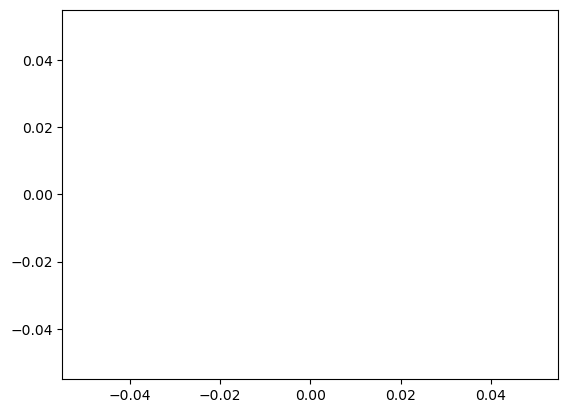

In [21]:
### plot Lift coefficient

lift_coefficient = np.array(Liftreport.out)
print('  stepLU        ', 'timePU        ', 'Cl')
print(lift_coefficient) # prints: stepLU, timePU, value
plt.figure
plt.plot(lift_coefficient[4000:,0],lift_coefficient[4000:,2])

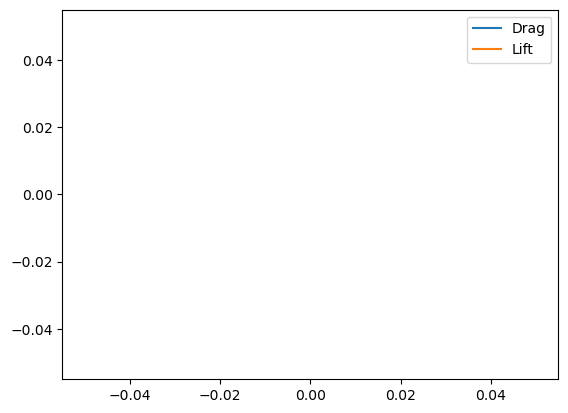

In [22]:
### plot Drag coefficient AND Lift Coefficient

drag_coefficient = np.array(Dragreport.out)
plt.figure
plt.plot(drag_coefficient[10000:,1],drag_coefficient[10000:,2])
lift_coefficient = np.array(Liftreport.out)
plt.plot(lift_coefficient[10000:,1],lift_coefficient[10000:,2])
plt.legend(labels=["Drag", "Lift"])

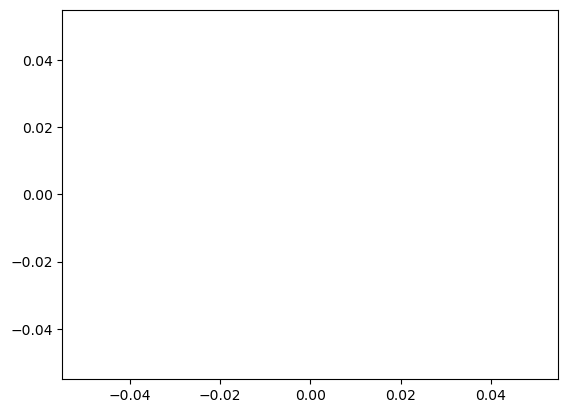

In [23]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

plt.figure
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_max_list[10000:])
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_min_list[10000:])
plt.plot(np.arange(len(DragObservable.rho_max_list[10000:]))+10000,DragObservable.rho_mean_list[10000:])

In [24]:
# save notebook to simulation_output

shutil.copy(str(os.getcwd())+"/cylinder2D_development.ipynb",output_path+dir_name+"/script.ipynb")



'/mnt/ScratchHDD1/Max_Scratch/lbm_simulations/data_230309_145913/script.ipynb'